In [8]:
%load_ext autoreload
%autoreload 2

from mcmc_Correlations import *
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#importing dti_log matrix
with open('DTI_avg_log.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
DTI_log = pd.DataFrame(data, dtype = 'float64')
DTI_log= DTI_log.values

#importing dti matrix
with open('DTI_avg.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
DTI = pd.DataFrame(data, dtype = 'float64')
DTI= DTI.values
max_value = np.max(DTI)
DTI = DTI / max_value

#importing fmri matrix
with open('fMRI_avg.csv', 'r') as file:
    reader = csv.reader(file, delimiter=',')
    data = list(reader)
fMRI = pd.DataFrame(data, dtype = 'float64')
fMRI = fMRI.values

c:\Users\conor\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\conor\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[0.8767016229712858, 0.5138476903870162, 0.7281622971285893]


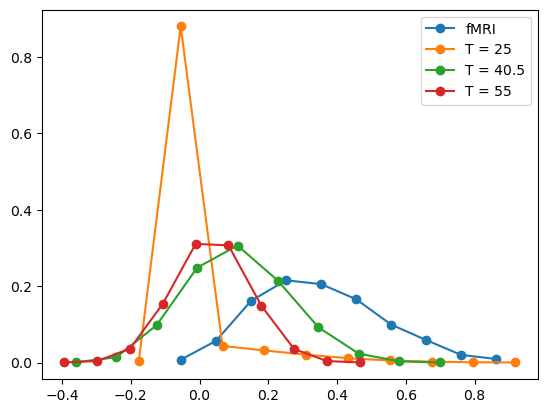

In [4]:
temps =[25, 40.5, 55] # T = 40.5 for n=90 random # T = 21 for DTI_log

#fMRI for comaprison
matrix = fMRI
rows = len(matrix)
cols = len(matrix[0])
fmri_corrs = []
for i in range(rows):
    for j in range(cols):
        if i != j:
            fmri_corrs.append(matrix[i][j])

hist_second, bins_second = np.histogram(fmri_corrs, bins=10)
hist_second = hist_second / len(fmri_corrs)
bin_centers_second = (bins_second[:-1] + bins_second[1:]) / 2
plt.plot(bin_centers_second, hist_second, '-o', label='fMRI')


# Correlation distributions for n=90 random networks for different temperatures
kolmogorov_values = []
for T in temps:
    a, b, c, d, mean_corr, corr_list = multi_metropolis(100, 5000, T, 90, 0, DTI, 0) #use_input = 2 so DTI is being used

    '''###
    #This part uses mean of all the metropolis runs
    all_corrs = []
    matrix = mean_corr
    rows = len(matrix)
    cols = len(matrix[0])
    for i in range(rows):
        for j in range(cols):
            if i != j:
                all_corrs.append(matrix[i][j])

    all_corrs = np.array(all_corrs, dtype=np.float64)
    all_corrs = np.nan_to_num(all_corrs, nan=0)

    hist, bins = np.histogram(all_corrs, bins=10)
    hist = hist / len(all_corrs)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.plot(bin_centers, hist, '-o', label=f'{T}')
    ###'''
    ###
    #This part does not use the mean of the runs but collects all the correlations of all the runs
    all_corrs = []
    for i in range(len(corr_list)):
        matrix = corr_list[i]
        rows = len(matrix)
        cols = len(matrix[0])
        for i in range(rows):
            for j in range(cols):
                if i != j:
                    all_corrs.append(matrix[i][j])

    all_corrs = np.array(all_corrs, dtype=np.float64)
    all_corrs = np.nan_to_num(all_corrs, nan=0)

    hist, bins = np.histogram(all_corrs, bins=10)
    hist = hist / len(all_corrs)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.plot(bin_centers, hist, '-o', label=f'T = {T}')
    ###


    statistic, p_value = stats.ks_2samp(fmri_corrs, all_corrs)
    kolmogorov_values.append(statistic)


print(kolmogorov_values)

plt.legend()
plt.show()

In [12]:
#Investigating how breaking connections affects critical temperature
fractions = np.linspace(0,0.95,15)
temperatures = np.linspace(1, 42, 50)

Tc_list = []

for f in fractions:
    sim_data = run_simulation(10, 2500, temperatures, 90, f, DTI, 1) #use_input = 1 (last variable) so fractions of zeros being used
    Tc_list.append(temperatures[sim_data[4]])


c:\Users\conor\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\conor\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


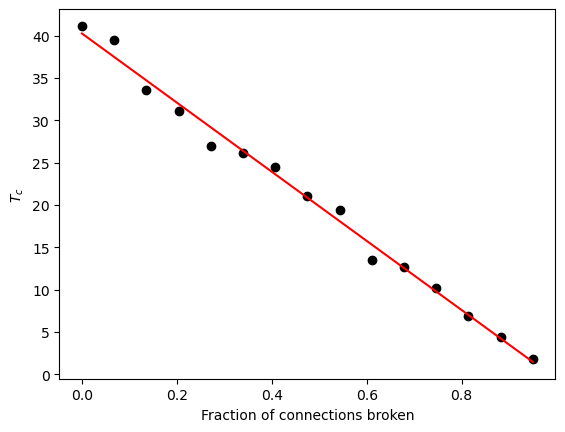

In [13]:
def fit_line(x, y):
    coefficients = np.polyfit(x, y, deg=1)
    slope, intercept = coefficients
    def fitted_line(x):
        return slope * x + intercept
    return fitted_line

x_data, y_data = fractions, Tc_list
get_Tc = fit_line(x_data, y_data) #function

fitted_line = fit_line(x_data, y_data)
x_plot = np.linspace(np.min(x_data), np.max(x_data), 100)
y_plot = fitted_line(x_plot)
plt.scatter(x_data, y_data, color='k', label='Data')
plt.plot(x_plot, y_plot, color='red', label='Fitted Line')

plt.xlabel('Fraction of connections broken')
plt.ylabel('$T_c$')

plt.show()


In [21]:
# Function that gets the Kolmogorov-Smirnov statistic between fMRI distribution 
# and a distribution obtained from using a specific connectivity matrix 
def get_K(T, input_matrix, fmri_corrs): 
    a, b, c, d, mean_corr, corr_list = multi_metropolis(25, 3000, T, 90, 0, input_matrix, 0)
    all_corrs = []
    for i in range(len(corr_list)):
        matrix = corr_list[i]
        rows = len(matrix)
        cols = len(matrix[0])
        for i in range(rows):
            for j in range(cols):
                if i != j:
                    all_corrs.append(matrix[i][j])

    all_corrs = np.array(all_corrs, dtype=np.float64)
    all_corrs = np.nan_to_num(all_corrs, nan=0) #just sets all nans to 0, bad

    statistic, p_value = stats.ks_2samp(fmri_corrs, all_corrs)

    return statistic

In [24]:
#The implemented basic hill-climbing algorithm
#starts with a random J, breaks or creates a connection then compares with dMRI distribution using KS statistic
def hill_climb(n):
    
    #first do fmri
    matrix = fMRI
    rows = len(matrix)
    cols = len(matrix[0])
    fmri_corrs = []
    for i in range(rows):
        for j in range(cols):
            if i != j:
                fmri_corrs.append(matrix[i][j])

    input_matrix = conn_matrix_basic(n)
    T = get_Tc(0)
    K = get_K(T, input_matrix, fmri_corrs)
    print('initial K =', K)

    i=0
    while K > 0.475:
        i+= 1
        new_matrix, f = break_or_create_connection(input_matrix)
        new_T = get_Tc(f)
        new_K = get_K(new_T, new_matrix, fmri_corrs)
        print('new_K = ', new_K)

        if new_K <= K:
            print('A change was made!')
            input_matrix = new_matrix
            K = new_K
        else:
            pass 
        print(K)
        if i % 10 == 0:
            print('at iteration', i, 'number of connections = ', np.count_nonzero(input_matrix)/2)
    print(i)
    
    return input_matrix

In [25]:
M = hill_climb(90) #has to be 90

graph = nx.from_numpy_matrix(M)
clustering_coefficient = nx.average_clustering(graph)

print(clustering_coefficient)

initial K = 0.5204594257178526
change entry: 40 23
new_K =  0.5251335830212235
0.5204594257178526
change entry: 18 17
new_K =  0.5387066167290886
0.5204594257178526
change entry: 3 0
new_K =  0.4822172284644195
A change was made!
0.4822172284644195
change entry: 79 27
new_K =  0.5328838951310861
0.4822172284644195
change entry: 25 10
new_K =  0.5750911360799001
0.4822172284644195
change entry: 22 21
new_K =  0.5234656679151061
0.4822172284644195
change entry: 74 47
new_K =  0.5663121098626717
0.4822172284644195
change entry: 47 23
new_K =  0.5202796504369538
0.4822172284644195
change entry: 16 4
new_K =  0.5950461922596754
0.4822172284644195
change entry: 66 44
new_K =  0.5314357053682897
0.4822172284644195
at iteration 10 number of connections =  4004.0
change entry: 17 7
new_K =  0.5452983770287141
0.4822172284644195
change entry: 61 10
new_K =  0.5368289637952559
0.4822172284644195
change entry: 88 81
new_K =  0.5517103620474407
0.4822172284644195
change entry: 68 21
new_K =  0.5099